Loading preprocessed training data...
Training data loaded: 25380 samples
Loading preprocessed validation data...
Validation data loaded: 24844 samples
Loading preprocessed evaluation data...
Evaluation data loaded: 71237 samples
Optimizing One-Class SVM using validation data...
Best parameters: {'nu': 0.3, 'gamma': 0.01, 'kernel': 'rbf'}
Best validation AUC: 0.8383
Evaluating on validation data...
Validation Results:
ROC AUC Score: 0.8383
Accuracy: 0.8978
Recall: 0.0059
Confusion Matrix:
[[22290     6]
 [ 2533    15]]
Classification Report:
              precision    recall  f1-score   support

       Spoof       0.90      1.00      0.95     22296
   Bona fide       0.71      0.01      0.01      2548

    accuracy                           0.90     24844
   macro avg       0.81      0.50      0.48     24844
weighted avg       0.88      0.90      0.85     24844

Evaluating on evaluation data...
Evaluation Results:
ROC AUC Score: 0.8299
Accuracy: 0.8907
Recall: 0.0024
Confusion Matrix:


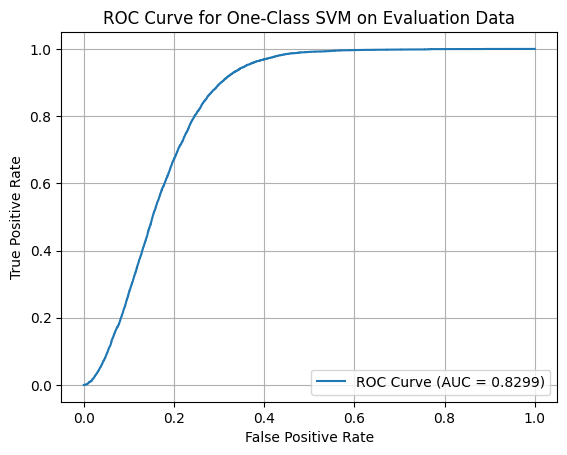

Showing 5 examples of evaluation predictions:
Example 1: Predicted = Spoof, Actual = Spoof


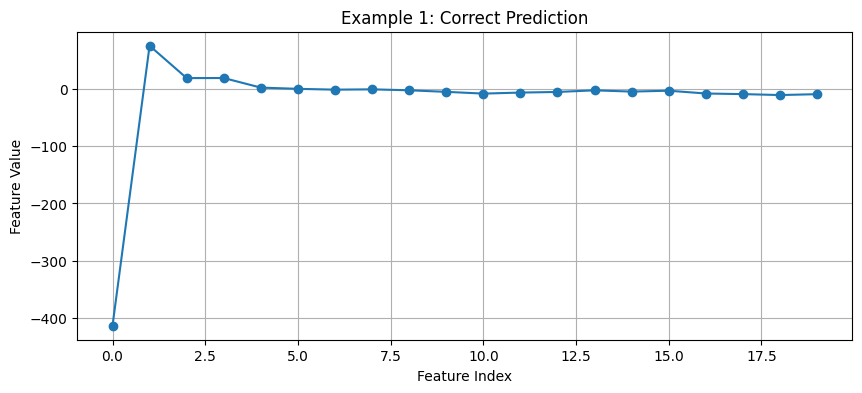

Example 2: Predicted = Spoof, Actual = Spoof


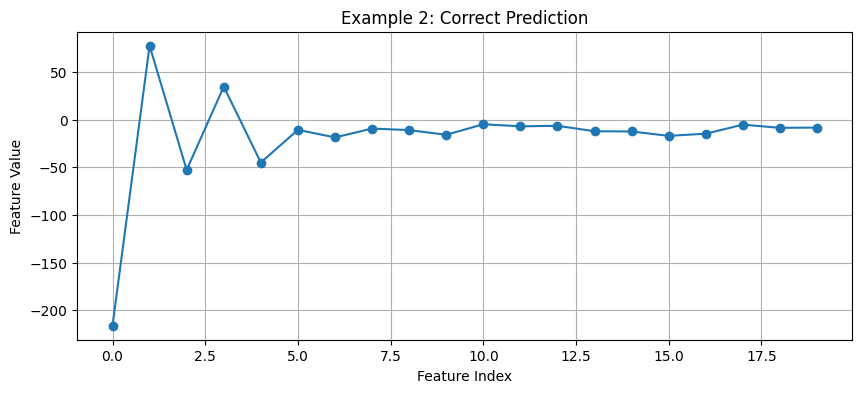

Example 3: Predicted = Spoof, Actual = Spoof


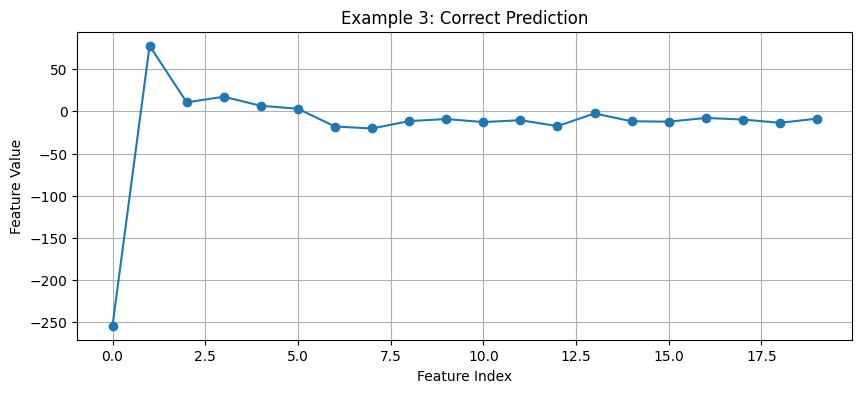

Example 4: Predicted = Spoof, Actual = Spoof


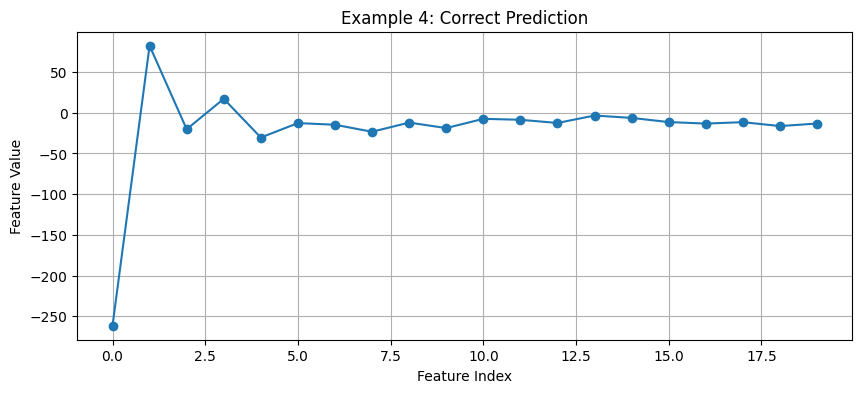

Example 5: Predicted = Spoof, Actual = Spoof


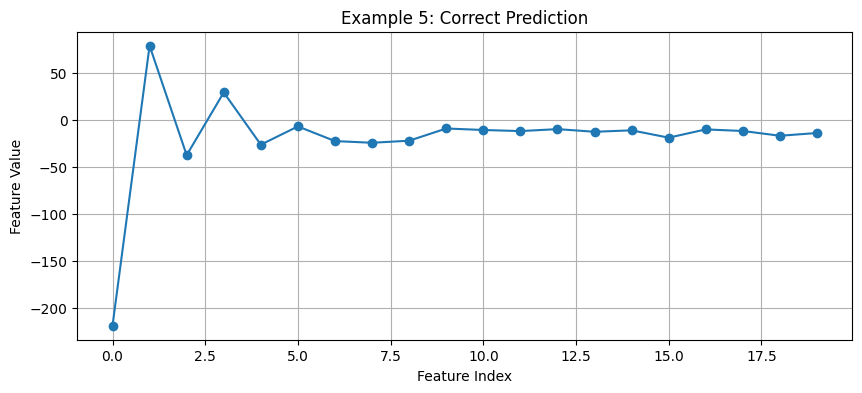

In [6]:
import pickle
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load preprocessed data
def load_preprocessed_file(file_path):
    """
    Load a preprocessed dataset file saved as a pickle (.pkl) file.

    Args:
        file_path (str): Path to the preprocessed file.

    Returns:
        dict: A dictionary containing 'features', 'labels', and 'file_paths'.
    """
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

# Paths to preprocessed datasets
TRAIN_FILE = "preprocessed_simple_data/train_100percent_features_labels.pkl"
DEV_FILE = "preprocessed_simple_data/dev_100percent_features_labels.pkl"
EVAL_FILE = "preprocessed_simple_data/eval_100percent_features_labels.pkl"

# Load datasets
print("Loading preprocessed training data...")
train_data = load_preprocessed_file(TRAIN_FILE)
print(f"Training data loaded: {len(train_data['features'])} samples")

print("Loading preprocessed validation data...")
dev_data = load_preprocessed_file(DEV_FILE)
print(f"Validation data loaded: {len(dev_data['features'])} samples")

print("Loading preprocessed evaluation data...")
eval_data = load_preprocessed_file(EVAL_FILE)
print(f"Evaluation data loaded: {len(eval_data['features'])} samples")

# Extract features and labels
X_train = np.array(train_data["features"])
y_train = np.array(train_data["labels"])
X_dev = np.array(dev_data["features"])
y_dev = np.array(dev_data["labels"])
X_eval = np.array(eval_data["features"])
y_eval = np.array(eval_data["labels"])

# Train One-Class SVM with hyperparameter optimization
print("Optimizing One-Class SVM using validation data...")

# Filter only bona fide samples for training
X_train_bona_fide = X_train[y_train == 1]

# Define parameter grid
param_grid = {
    'nu': [0.1, 0.2, 0.3, 0.5],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid', 'linear']
}

best_params = None
best_score = -float('inf')

# Manual grid search for validation
for kernel in param_grid['kernel']:
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            model = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
            model.fit(X_train_bona_fide)
    
            # Evaluate on validation set
            dev_scores = model.decision_function(X_dev)
            auc = roc_auc_score(y_dev, dev_scores)
    
            if auc > best_score:
                best_score = auc
                best_params = {'nu': nu, 'gamma': gamma, 'kernel': kernel}

print(f"Best parameters: {best_params}")
print(f"Best validation AUC: {best_score:.4f}")

# Train final model with best parameters
final_model = OneClassSVM(**best_params)
final_model.fit(X_train_bona_fide)

# Evaluate on the validation set
print("Evaluating on validation data...")
dev_scores = final_model.decision_function(X_dev)
dev_predictions = final_model.predict(X_dev)

# Map predictions to binary labels
dev_predicted_labels = (dev_predictions == 1).astype(int)

# Compute metrics
roc_auc_dev = roc_auc_score(y_dev, dev_scores)
accuracy_dev = accuracy_score(y_dev, dev_predicted_labels)
recall_dev = recall_score(y_dev, dev_predicted_labels, pos_label=1)
dev_conf_matrix = confusion_matrix(y_dev, dev_predicted_labels)
dev_class_report = classification_report(y_dev, dev_predicted_labels, target_names=["Spoof", "Bona fide"])

# Print metrics for validation
print("Validation Results:")
print(f"ROC AUC Score: {roc_auc_dev:.4f}")
print(f"Accuracy: {accuracy_dev:.4f}")
print(f"Recall: {recall_dev:.4f}")
print("Confusion Matrix:")
print(dev_conf_matrix)
print("Classification Report:")
print(dev_class_report)

# Evaluate on the evaluation set
print("Evaluating on evaluation data...")
eval_scores = final_model.decision_function(X_eval)
eval_predictions = final_model.predict(X_eval)

# Map predictions to binary labels
eval_predicted_labels = (eval_predictions == 1).astype(int)

# Compute metrics
roc_auc_eval = roc_auc_score(y_eval, eval_scores)
accuracy_eval = accuracy_score(y_eval, eval_predicted_labels)
recall_eval = recall_score(y_eval, eval_predicted_labels, pos_label=1)
eval_conf_matrix = confusion_matrix(y_eval, eval_predicted_labels)
eval_class_report = classification_report(y_eval, eval_predicted_labels, target_names=["Spoof", "Bona fide"])

# Print metrics for evaluation
print("Evaluation Results:")
print(f"ROC AUC Score: {roc_auc_eval:.4f}")
print(f"Accuracy: {accuracy_eval:.4f}")
print(f"Recall: {recall_eval:.4f}")
print("Confusion Matrix:")
print(eval_conf_matrix)
print("Classification Report:")
print(eval_class_report)

# Save the trained model
with open("optimized_ocsvm_model.pkl", "wb") as model_file:
    pickle.dump(final_model, model_file)
print("Trained model saved successfully.")

# Plot ROC Curve for evaluation set
fpr, tpr, thresholds = roc_curve(y_eval, eval_scores)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_eval:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for One-Class SVM on Evaluation Data")
plt.legend()
plt.grid()
plt.show()

# Visualize examples of predictions
num_examples = 5
print(f"Showing {num_examples} examples of evaluation predictions:")
for i in range(min(num_examples, len(X_eval))):
    print(f"Example {i + 1}: Predicted = {'Bona fide' if eval_predicted_labels[i] == 1 else 'Spoof'}, Actual = {'Bona fide' if y_eval[i] == 1 else 'Spoof'}")
    plt.figure(figsize=(10, 4))
    plt.plot(X_eval[i], marker="o")
    plt.title(f"Example {i + 1}: {'Correct' if eval_predicted_labels[i] == y_eval[i] else 'Incorrect'} Prediction")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.show()
